<a href="https://colab.research.google.com/github/thirdformant/cats_dogs_audio/blob/master/notebooks/cats_dogs_audio_torchaudio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Audio classification of cats and dogs

Training a machine learning classification model on images of cats and dogs is a common introductory problem. With modern convolutional neural network (CNN) architectures and transfer learning, it is now possible to achieve near-perfect levels of classification accuracy as demonstrated very effectively (and efficiently!) early on in the [fast.ai deep learning MOOC](https://course.fast.ai/). When browsing through the datasets on Kaggle some time ago, I stumbled upon the [Audio Cats and Dogs](https://www.kaggle.com/mmoreaux/audio-cats-and-dogs/home) data, which presents itself as 'the audio counterpart' to the typical image classification problem. As someone with a background in acoustic phonetics, this has rather a lot of appeal. In addition, the dataset brings some new challenges to classification:  first, the audio data requires considerable preprocessing if a CNN is to be used, and second, the data consists of only 277 files. More on both these topics later.

This notebook comprises two major parts. The first is a partial implementation of the approaches described in Huzaifah (2017) in his experimentation regarding CNN-based classification of environmental sound data. While the CNN architectures he used were implemented in TensorFlow, I have chosen instead to use Pytorch. The second section ((improves on the approaches used by Huzaifah, increasing the overall classification accuracy using TODO: finish this once the implementation is done)).

# Libraries and setup

[Librosa](http://librosa.github.io/librosa/) is a general-purpose audio processing and analysis library.

In [46]:
!apt-get install sox libsox-dev libsox-fmt-all
!pip3 install git+git://github.com/pytorch/audio
!apt-get install python3-gdbm

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libsox-dev is already the newest version (14.4.2-3).
libsox-fmt-all is already the newest version (14.4.2-3).
sox is already the newest version (14.4.2-3).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.
  Cloning git://github.com/pytorch/audio to /tmp/pip-req-build-j3o8iymq
  Stored in directory: /tmp/pip-ephem-wheel-cache-sanoprlz/wheels/4e/7c/c5/0d946acbaccad9fe62590374454c4cf135846c9c96fce3ac75
Successfully built torchaudio
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-gdbm is already the newest version (3.6.7-1~18.04).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


In [0]:
import os
import dill
import pickle
from pathlib import Path
from typing import Optional
from collections import Counter

import numpy as np
import pandas as pd

import librosa # Audio library

# Data viz
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix

# Deep learning
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

# transforms
import torchvision.transforms as transforms
import torchaudio.transforms

In [48]:
torch.cuda.is_available()

True

In [0]:
use_cuda = True

if use_cuda and torch.cuda.is_available():
    device = torch.device("cuda")

In [50]:
# Connecting to google drive
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Reading data

I created a csv file containing the filename and the file labels. This can be passed to the Pytorch Dataset class defined in the next section.

In [0]:
# Paths
ROOT_PATH = Path('/content/gdrive/My Drive/data/cats_dogs_audio/cats_dogs/')
CSV_PATH = Path('/content/gdrive/My Drive/data/cats_dogs_audio/all_data.csv')
MODEL_PATH = Path('/content/gdrive/My Drive/data/cats_dogs_audio/models')

In [0]:
# # Creates the csv file. Commented out because I only needed to run it once

# all_data = {
#     'label': [],
#     'filename': []
# }


# files_list = os.listdir(ROOT_PATH)
# for f in files_list:
#     if Path(f).suffix == '.wav':
#         all_data['filename'].append(f)
#         if 'cat' in f:
#             all_data['label'].append(0)
#         else:
#             all_data['label'].append(1)

# data_df = pd.DataFrame(all_data).iloc[:, ::-1] # Reverse the column order
# data_df.to_csv(CSV_PATH, index=False)

In [0]:
data_df = pd.read_csv(CSV_PATH)

In [54]:
print(f'The distribution of classes in the data is: {Counter(data_df["label"])}')
print(f'The shape of the data is: {data_df.shape}')

The distribution of classes in the data is: Counter({0: 164, 1: 113})
The shape of the data is: (277, 2)


# CNN architectures

Huzaifah (2017: 3) defined two CNN architectures, with Conv-5 being deeper than Conv-3. For each network, two different convolutional filters were considered, a  $3\times3$ filter and an $M\times3$ filter where $M$ spans the FFT frequency bins. So far, only the $3\times3$ filter networks are implemented here.

In [0]:
def outputSize(in_size, kernel_size, stride, padding):

    output = int((in_size - kernel_size + 2*(padding)) / stride) + 1
    return(output)

In [0]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
    
    def forward(self, x):
        return self.func(x)
    
class PrintLambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        self.func(x)
        return x

## Conv-3

### Narrowband conv-3

In [0]:
nb_conv3_model = nn.Sequential(
    nn.Conv2d(1, 180, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4, stride=4, padding=1),
    nn.Dropout(0.5),
    Lambda(lambda x: x.view(-1, 180 * 9 * 13)),
    nn.Linear(180 * 9 * 13, 800),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(800, 2)
)

### Wideband conv-3

In [0]:
wb_conv3_model = nn.Sequential(
    nn.Conv2d(1, 180, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4, stride=4, padding=1),
    nn.Dropout(0.5),
    Lambda(lambda x: x.view(-1, 180 * 39 * 3)),
    nn.Linear(180 * 39 * 3, 800),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(800, 2)
)

## Conv-5

### Narrowband conv-5

In [0]:
nb_conv5_model = nn.Sequential(
    nn.Conv2d(1, 24, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
    nn.Dropout(0.5),
    nn.Conv2d(24, 48, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
    nn.Conv2d(48, 96, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    Lambda(lambda x: x.view(-1, 96 * 10 * 14)),
    nn.Linear(96 * 10 * 14, 800),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(800, 2)
)

### Wideband conv-5

In [0]:
wb_conv5_model = nn.Sequential(
    nn.Conv2d(1, 24, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
    nn.Dropout(0.5),
    nn.Conv2d(24, 48, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
    nn.Conv2d(48, 96, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    Lambda(lambda x: x.view(-1, 96 * 40 * 4)),
    nn.Linear(96 * 40 * 4, 800),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(800, 2)
)

## CNN training functions

Defining a class for preparing the data and training the CNNs.

In [0]:
class _WrappedDataLoader:
    def __init__(self, dl, func, dev):
        self.dl = dl
        self.func = func
        self.dev = dev

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b, self.dev))

            

class FitCNN(object):
    """
    Functions for training a CNN
    Args:
        train_ds: pytorch Dataset of training data
        train_ds: pytorch Dataset of validation data
    """
    def __init__(self, train_ds, valid_ds, bs, preprocess_func, model, epochs,
                 loss_func, opt, dev):
        self.dev = dev
        self.train_ds = train_ds
        self.valid_ds = valid_ds
        self.bs = bs
        self.preprocess = preprocess_func
        self.model = model
        self.epochs = epochs
        self.loss_func = loss_func
        self.opt = opt
        
        self.train_loss = []
        self.valid_loss = []
        self.epoch_accuracy = []
        
        self.preds = []
        self.actuals = []
        self.accuracy = []
        
    
    def fit(self):
        
        train_dl, valid_dl = self._get_data(self.train_ds, self.valid_ds, self.bs)
        train_dl = _WrappedDataLoader(train_dl, self.preprocess, self.dev)
        valid_dl = _WrappedDataLoader(valid_dl, self.preprocess, self.dev)
        
        if self.dev == torch.device("cuda"):
            print("Training the model on the GPU")
        else:
            print("Training the model on the CPU")
        
        self.model.apply(self._weights_init)
        
        
        
        for epoch in range(self.epochs):
            
            running_loss = 0.0
            
            self.model.train()
            for xb, yb in train_dl:
                t_loss, _ = self._batch_loss(self.model, self.loss_func, xb, yb, self.opt)
                running_loss += t_loss
            train_loss = (running_loss/len(train_dl))
            self.train_loss.append(train_loss)
        
        
            self.model.eval()
            with torch.no_grad():
                
                losses, nums = zip(
                    *[self._batch_loss(self.model, self.loss_func, xb, yb) for xb, yb in valid_dl]
                )
                val_loss = (losses[0] / len(valid_dl))
                self.valid_loss.append(val_loss)
                
                
            if epoch % 5 == 0:
                print(f"Epoch: {epoch}; Train loss: {train_loss}; Validation loss: {val_loss}")
            running_loss = 0.0
            acc = self._accuracy_score(valid_dl)
            self.epoch_accuracy.append(acc[2])

        self.preds, self.actuals, self.accuracy = self._accuracy_score(valid_dl,
                                                                      print_score=True)
    
    def _get_data(self, train_ds, valid_ds, bs):
        return (
            DataLoader(train_ds, batch_size=bs, shuffle=True),
            DataLoader(valid_ds, batch_size=bs*2)
        )
    
    
    def _batch_loss(self, model, loss_func, xb, yb, opt=None):
        loss = loss_func(model(xb), yb)

        if opt is not None:
            loss.backward()
            opt.step()
            opt.zero_grad()
        return loss.item(), len(xb)
    
    
    def _accuracy_score(self, valid_dl, print_score=False):
        correct = 0
        total = 0
        preds = []
        labels = []
        with torch.no_grad():
            for data in valid_dl:
                b_images, b_labels = data
                outputs = self.model(b_images)
                _, b_predicted = torch.max(outputs.data, 1)
                total += b_labels.size(0)
                correct += (b_predicted == b_labels).sum().item()
                labels.extend(b_labels.cpu().tolist())
                preds.extend(b_predicted.cpu().cpu().tolist())
        accuracy = (100 * correct / total)
        if print_score:
            print("-" * 40)
            print(f'Accuracy: {accuracy}')
            print(f"Confusion matrix:\n {confusion_matrix(labels, preds)}")
            print("-" * 40)
        return preds, labels, accuracy
        
        
    def _weights_init(self, m):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight.data,
                                         nn.init.calculate_gain('relu'))
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight.data,
                                         nn.init.calculate_gain('relu'))
            m.bias.data.zero_()

### Cross validation

Class for n-fold cross-validation of CNN.

In [0]:
class CVModel:
    """
    Create and train a CNN with n-fold cross-validation
    """
    def __init__(self, X, nfolds, root, audio_trfms, image_trfms, dur,
                librosa=False, dev=None):
        self.X = X
        self.y = self.X['label']
        self.nfolds = nfolds
        
        self.root = root
        self.audio_trfms = audio_trfms
        self.image_trfms = image_trfms
        self.dur = dur
        self.librosa = librosa
        
        self.model = ''
        self.loss_func = ''
        self.opt = ''
        self.params = {}
        
        self.train_loss = []
        self.valid_loss = []
        self.epoch_accuracy = []
        
        self.acc_scores = []
        self.train_preds = []
        self.train_actual = []
        
        if dev:
            self.dev = dev
        elif torch.cuda.is_available():
            self.dev = torch.device("cuda")
        else:
            self.dev = torch.device("cpu")
    
    def train_cnn(self, model, params):
        # CV setup
        self.model = model.to(self.dev)
        self.params = params
        
        skf = StratifiedKFold(n_splits=self.nfolds, random_state=42, shuffle=True)
        fold_count = 1
        
        for train_index, valid_index in skf.split(np.zeros(self.X.shape[0]), self.y):
            print(f"Fold {fold_count} / {self.nfolds}:")
            # Splits data into training and validation sets
            X_train, X_valid = self.X.iloc[train_index], self.X.iloc[valid_index]
            
            train_ds = AudioFeatureDataset(X_train, self.root,
                                           audio_transform=self.audio_trfms,
                                           image_transform=self.image_trfms,
                                           duration=self.dur,
                                           librosa=self.librosa)
                        
            valid_ds = AudioFeatureDataset(X_valid, self.root,
                                           audio_transform=self.audio_trfms,
                                           image_transform=self.image_trfms,
                                           duration=self.dur,
                                           librosa=self.librosa)
            
            # Trains the model and gets predictions and accuracy scores
            opt = optim.Adam(self.model.parameters(),
                             lr=self.params['lr'],
                             weight_decay=self.params['l2'])
            loss_func = nn.CrossEntropyLoss()
            
            model_fitter = FitCNN(train_ds, valid_ds, bs=self.params['bs'],
                                  preprocess_func=self.params['preprocess'],
                                  model=self.model,
                                  epochs=self.params['epochs'],
                                  loss_func=loss_func,
                                  opt=opt, dev=self.dev)
            
            
            model_fitter.fit()

            # Process model results
            self.train_loss.append(model_fitter.train_loss)
            self.valid_loss.append(model_fitter.valid_loss)
            self.epoch_accuracy.append(model_fitter.epoch_accuracy)
            self.train_preds.extend(model_fitter.preds)
            self.train_actual.extend(model_fitter.actuals)
            self.acc_scores.append(model_fitter.accuracy)
            fold_count += 1
            
        # Print model results summary
        print("=" * 40)
        print(f"Accuracy scores: {self.acc_scores}")
        print(f"Mean accuracy: {np.mean(self.acc_scores)}")
        print(f"Accuracy sd: {np.std(self.acc_scores)}")
        print(f"Median accuracy: {np.median(self.acc_scores)}")
        print(f"Confusion matrix:\n{confusion_matrix(self.train_actual, self.train_preds)}")
        print("-" * 40)
        print(f"Model parameters:\n {self.params}")
        print("=" * 40)

In [0]:
def preprocess_nb(x, y, dev):
    return x.view(-1, 1, 37, 50).to(dev), y.to(dev)

def preprocess_wb(x, y, dev):
    return x.view(-1, 1, 154, 12).to(dev), y.to(dev)

# CNN training

## Feature overview

Waveforms show changes in the signal, especially in its amplitude (loudness), over time and are therefore representations of the signal in the *time domain*. This is, however, only one aspect of the signal. When it comes to training audio classification or e.g. speech recognition models, better results are achieved when considering how the frequency of the signal, rather than its amplitude, changes over time. These are known as *time-frequency* representations, the best-known of which is the spectrogram.

While Huzaifah (2017) created four time-frequency representations, only two are currently implemented here:
- Linear-scaled Short-time Fourier Transform (STFT) spectrograms
- mel-scaled STFT spectrograms.

In addition, Mel-frequency Cepstral Coefficients (MFCCs) were also extracted from the input signal.

Prior to feature extractions, all raw audio was either clipped or padded to a 4 second duration.

## Pytorch dataset definition

Pytorch datasets allow the audio features to be extracted and transformed 'on the fly' when needed, rather than being extracted in advance and saved separately.

The current implementation of this allows for two options. The first uses `librosa` to load the audio data and perform the transformations. This was the approach taken by Huzaifah (2017) and so produces the most directly comparable results. However, `librosa` is limited to the CPU and is therefore slow. The second option uses the transformations in `torchaudio`, which can be run on a CUDA-compatible GPU. Being the faster option, this is the default here.

In [0]:
class AudioFeatureDataset(Dataset):
    def __init__(self, dataframe:pd.DataFrame, root_path:Path,
                 offset:int=0, duration:int=None, sr:int=16000,
                 audio_transform=None, image_transform=None,
                 librosa=False):
        """
        Args:
            dataframe: Pandas dataframe of format {labels, filename}
            root: root path for input data dir
            offset: ?
            duration: desired duration of the audio signal
            sr: desired sampling rate of the audio signal
            transform: transformations to be applied to the data
        """
        self.root = root_path
        
        self.data = dataframe
        self.files = np.array(self.data.iloc[:, 1])
        self.classes = np.array(self.data.iloc[:, 0])
        
        self.sr = sr
        self.offset = offset
        self.duration = duration
        
        self.audio_transform = audio_transform
        self.image_transform = image_transform
        self.librosa = librosa
        
        self.dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        
    def __getitem__(self, index):
        # Stuff
        file = self.files[index]
        label = self.classes[index]
        
        if self.librosa:
            signal, sr = librosa.core.load(self.root / file, sr=self.sr,
                                       offset=self.offset,
                                       duration=self.duration)
            if self.duration:
                signal = self._pad_audio(signal)
                
            signal = self.audio_transform(signal)
            signal = np.abs(signal)
            signal = np.expand_dims(signal, axis=2)
            signal = self.image_transform(signal.astype("uint8"))
            
            
        else:
            signal = torchaudio.load(self.root / file, offset=self.offset)[0].to(self.dev)
        
            if self.duration:
                num_samples = self.sr * self.duration
                pad_trfms = transforms.Compose([
                    torchaudio.transforms.PadTrim(max_len=num_samples)])
                signal = pad_trfms(signal)
            
            signal = self.audio_transform(signal)
            signal = signal.transpose(1, 2)
            signal = self.image_transform(signal.cpu().type(torch.uint8))

        return signal, label
    

    def __len__(self):
        return len(self.files)
    
    def _pad_audio(self, signal):
        '''
        From https://stackoverflow.com/a/32477869 with comments and minor
        changes to variable names for additional clarity
        '''
        # Calculate target number of samples
        n_target = int(self.sr * self.duration)
        # Calculate number of zero samples to append
        shape = signal.shape
        # Create the target shape    
        padding = n_target - shape[0]
        #   print("Padding with %s seconds of silence" % str(N_pad/fs) )
        shape = (padding,) + shape[1:]
        # Stack only if there is something to append    
        if shape[0] > 0:                
            if len(shape) > 1:
                return np.vstack((np.zeros(shape),
                                signal))
            else:
                return np.hstack((np.zeros(shape),
                                signal))
        else:
            return signal

## Short-time Fourier Transform (STFT) features

Put very briefly, any periodic waveform can be represented by as a sum (possibly infinite) of sinusoids of different frequency and phase. Fourier transforms perform this decomposition on a signal, revealing its frequency and phase components.

Fourier transforms are typically applied to the signal as a whole and thus do not reveal how the frequency and phase components of the signal change over time. This can, however, be done with the STFT. First, the signal is divided into overlapping segments of equal length and a window function applied to these segments. The transform is then taken for each of these windows, with the complex-valued results being added to a matrix. 

The spectrogram of the signal is then defined as the magnitude (the absolute value) of the STFT matrix squared.

The STFT of a signal is given by: 

\begin{equation*}
X[m, \omega] = \sum_{k=0}^{\textrm{win_length}-1}\textrm{input}[m] \cdot \textrm{window}[n - m] \cdot \exp{\bigg(-j\frac{2\pi \cdot \omega k}{\textrm{win_length}}\bigg)}
\end{equation*}

Varying the window length (`win_length`) affects the resolution of the STFT in terms of time and frequency. Longer windows capture higher frequencies, but show less change across time (as the time domain is split into fewer windows) and shorter windows show greater change in time in exchange for lower frequency resolution. The former are known as narrowband transforms and the latter as wideband transforms.

### Linear STFT spectrograms

In linear spectrograms, the STFT frequency bins are scaled linearly which is the unmodified output of the STFT.

Both wideband (`win_length` = 512) and narrowband (`win_length` = 2048) linear spectrograms were extracted from the input signal. In both cases the window hop length was $\textrm{win_len} / 2$. The STFT values were converted to the logarithmic scale (dB) and spectrogram values were normalised to $[-1, 1]$.

The final images were resized to 37$\times$50 pixels for narrowband spectrograms and 154$\times$12 pixels for wideband spectrograms with Lanczos resampling.

In [0]:
class LinearSpectrogram(object):
    """
    Creates a spectrogram from a raw audio signal using librosa
    Args:
        sr: sample rate
        n_fft: size of fft
    """
    def __init__(self, n_fft, sr=16000, hop_length=None, center=True):
        self.n_fft = n_fft
        self.sr = sr
        self.hop_length = hop_length if hop_length else self.n_fft // 2
        self.center = center
    
    def __call__(self, sig):
        stft = np.abs(librosa.core.stft(sig, n_fft=self.n_fft,
                                        hop_length=self.hop_length,
                                        center=self.center))
        spectrogram = librosa.amplitude_to_db(stft, ref=np.max)
        return spectrogram

In [0]:
"""
Parameters and transformations for narrowband linear STFT features
"""
nb_linear_params = {
    'n_fft': 512
}

nb_lin_transform_librosa = transforms.Compose([
    LinearSpectrogram(n_fft=nb_linear_params['n_fft'])
])

nb_lin_transform = transforms.Compose([
    torchaudio.transforms.Spectrogram(ws=nb_linear_params['n_fft']),
    torchaudio.transforms.SpectogramToDB()
])

nb_image_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((37, 50), 4),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [0]:
"""
Parameters and transformations for wideband linear STFT features
"""

wb_linear_params = {
    'n_fft': 2048
}

wb_lin_transform_librosa = transforms.Compose([
    LinearSpectrogram(n_fft=wb_linear_params['n_fft'])
])

wb_lin_transform = transforms.Compose([
    torchaudio.transforms.Spectrogram(ws=wb_linear_params['n_fft']),
    torchaudio.transforms.SpectogramToDB()
])

wb_image_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((154, 12), 4),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

#### Narrowband: Conv-3

In [0]:
%%time
nblinear_conv3_params = {
    'bs': 30,
    'preprocess': preprocess_nb,
    'epochs': 40,
    'lr': 0.01,
    'l2': 0.005
}

nblinear_conv3 = CVModel(data_df, 5, ROOT_PATH,
                        nb_lin_transform, nb_image_transform,
                        4)
nblinear_conv3.train_cnn(nb_conv3_model,
                        nblinear_conv3_params)

Fold 1 / 5:
Training the model on the GPU
Epoch: 0; Train loss: 10.553378269076347; Validation loss: 3.5221571922302246
Epoch: 5; Train loss: 0.4575492702424526; Validation loss: 0.5646775960922241
Epoch: 10; Train loss: 0.3641761261969805; Validation loss: 0.6798993349075317
Epoch: 15; Train loss: 0.40281124971807003; Validation loss: 0.5462304949760437
Epoch: 20; Train loss: 0.3812175281345844; Validation loss: 0.4601581394672394
Epoch: 25; Train loss: 0.4349023699760437; Validation loss: 0.579267680644989
Epoch: 30; Train loss: 0.4005952160805464; Validation loss: 0.43667182326316833
Epoch: 35; Train loss: 0.43348994478583336; Validation loss: 0.45967164635658264
----------------------------------------
Accuracy: 83.92857142857143
Confusion matrix:
 [[31  2]
 [ 7 16]]
----------------------------------------
Fold 2 / 5:
Training the model on the GPU
Epoch: 0; Train loss: 8.767217993736267; Validation loss: 3.2859854698181152
Epoch: 5; Train loss: 0.6203789822757244; Validation loss:

In [0]:
dill.dump(nblinear_conv3, open(MODEL_PATH / 'nblinear_conv3.p', 'wb'))

#### Wideband: Conv-3

In [0]:
%%time
wblinear_conv3_params = {
    'bs': 30,
    'preprocess': preprocess_wb,
    'epochs': 40,
    'lr': 0.01,
    'l2': 0.005
}

wblinear_conv3 = CVModel(data_df, 5, ROOT_PATH,
                        wb_lin_transform, wb_image_transform,
                        4)
wblinear_conv3.train_cnn(wb_conv3_model,
                        wblinear_conv3_params)

Fold 1 / 5:
Training the model on the GPU
Epoch: 0; Train loss: 18.413176506757736; Validation loss: 4.949497699737549
Epoch: 5; Train loss: 0.642618402838707; Validation loss: 0.7085475921630859
Epoch: 10; Train loss: 0.3471695240586996; Validation loss: 0.48274993896484375
Epoch: 15; Train loss: 0.3042116556316614; Validation loss: 0.49252867698669434
Epoch: 20; Train loss: 0.34167800284922123; Validation loss: 0.5105725526809692
Epoch: 25; Train loss: 0.31212384440004826; Validation loss: 0.5552797913551331
Epoch: 30; Train loss: 0.3177145794034004; Validation loss: 0.4660327136516571
Epoch: 35; Train loss: 0.3124060109257698; Validation loss: 0.5486910343170166
----------------------------------------
Accuracy: 82.14285714285714
Confusion matrix:
 [[26  7]
 [ 3 20]]
----------------------------------------
Fold 2 / 5:
Training the model on the GPU
Epoch: 0; Train loss: 8.592124529182911; Validation loss: 2.3407154083251953
Epoch: 5; Train loss: 0.5605775117874146; Validation loss: 

In [0]:
dill.dump(wblinear_conv3, open(MODEL_PATH / 'wblinear_conv3.p', 'wb'))

#### Narrowband: Conv-5

In [0]:
%%time
nblinear_conv5_params = {
    'bs': 30,
    'preprocess': preprocess_nb,
    'epochs': 40,
    'lr': 0.01,
    'l2': 0.005
}

nblinear_conv5 = CVModel(data_df, 5, ROOT_PATH,
                        nb_lin_transform, nb_image_transform,
                        4)
nblinear_conv5.train_cnn(nb_conv5_model,
                        nblinear_conv5_params)

Fold 1 / 5:
Training the model on the GPU
Epoch: 0; Train loss: 42.65596608072519; Validation loss: 0.680630624294281
Epoch: 5; Train loss: 0.6744551435112953; Validation loss: 0.6773127317428589
Epoch: 10; Train loss: 0.6794209331274033; Validation loss: 0.6782446503639221
Epoch: 15; Train loss: 0.6753525659441948; Validation loss: 0.6773771047592163
Epoch: 20; Train loss: 0.6746094077825546; Validation loss: 0.6784367561340332
Epoch: 25; Train loss: 0.6731995269656181; Validation loss: 0.6773982048034668
Epoch: 30; Train loss: 0.6798685565590858; Validation loss: 0.6772093176841736
Epoch: 35; Train loss: 0.6862751841545105; Validation loss: 0.6772938370704651
----------------------------------------
Accuracy: 58.92857142857143
Confusion matrix:
 [[33  0]
 [23  0]]
----------------------------------------
Fold 2 / 5:
Training the model on the GPU
Epoch: 0; Train loss: 25.222070202231407; Validation loss: 0.6865634918212891
Epoch: 5; Train loss: 0.6815138459205627; Validation loss: 0.6

In [0]:
dill.dump(nblinear_conv5, open(MODEL_PATH / 'nblinear_conv5.p', 'wb'))

#### Wideband: Conv-5

In [0]:
%%time
wblinear_conv5_params = {
    'bs': 30,
    'preprocess': preprocess_wb,
    'epochs': 40,
    'lr': 0.005,
    'l2': 0.005
}

wblinear_conv5 = CVModel(data_df, 5, ROOT_PATH,
                        wb_lin_transform, wb_image_transform,
                        4)
wblinear_conv5.train_cnn(wb_conv5_model,
                        wblinear_conv5_params)

Fold 1 / 5:
Training the model on the GPU
Epoch: 0; Train loss: 17.177576169371605; Validation loss: 0.670988917350769
Epoch: 5; Train loss: 0.5114524066448212; Validation loss: 0.6389636993408203
Epoch: 10; Train loss: 0.3983010873198509; Validation loss: 0.6288923025131226
Epoch: 15; Train loss: 0.35657840967178345; Validation loss: 0.6040942072868347
Epoch: 20; Train loss: 0.3423343114554882; Validation loss: 0.5483373403549194
Epoch: 25; Train loss: 0.3097329679876566; Validation loss: 0.6370822191238403
Epoch: 30; Train loss: 0.3300449922680855; Validation loss: 0.5301727056503296
Epoch: 35; Train loss: 0.26728958124294877; Validation loss: 0.5527859330177307
----------------------------------------
Accuracy: 76.78571428571429
Confusion matrix:
 [[26  7]
 [ 6 17]]
----------------------------------------
Fold 2 / 5:
Training the model on the GPU
Epoch: 0; Train loss: 11.39102479070425; Validation loss: 0.6936146020889282
Epoch: 5; Train loss: 0.5383040644228458; Validation loss: 0

In [0]:
dill.dump(wblinear_conv5, open(MODEL_PATH / 'wblinear_conv5.p', 'wb'))

### Mel-scale STFT spectrograms

`librosa.features.melspectrogram()` was used to extract a  [mel scaled](https://en.wikipedia.org/wiki/Mel_scale)  spectrogram by applying a mel filterbank of a specified size to the STFT frequency bin values.

128 mel bands were used for narrowband spectrograms and 512 for wideband spectrograms. As with linear spectrograms values were log scaled and normalised to $[-1, 1]$. Images were resized to 37$\times$50 pixels for narrowband spectrograms and 154$\times$12 pixels for wideband spectrograms with Lanczos resampling

In [0]:
class MelSpectrogram(object):
    """
    Creates a spectrogram from a raw audio signal using librosa
    This isn't ideal but...
    Args:
        sr: sample rate
        n_fft: size of fft
    """
    def __init__(self, n_fft, n_mels, sr=16000, hop_length=None):
        self.n_fft = n_fft
        self.sr = sr
        self.hop_length = hop_length if hop_length else self.n_fft // 2
        self.n_mels = n_mels
    
    def __call__(self, sig):
        stft = np.abs(librosa.feature.melspectrogram(sig, n_fft=self.n_fft,
                                                     hop_length=self.hop_length,
                                                     n_mels=self.n_mels))
        spectrogram = librosa.amplitude_to_db(stft, ref=np.max)
        return spectrogram

In [0]:
"""
Parameters and transformations for narrowband mel STFT features
"""
nb_mel_params = {
    'n_fft': 512,
    'n_mels': 128
}

nb_mel_transform_librosa = transforms.Compose([
    MelSpectrogram(n_fft=nb_mel_params['n_fft'],
                  n_mels=nb_mel_params['n_mels'])
])

nb_mel_transform = transforms.Compose([
    torchaudio.transforms.MelSpectrogram(ws=nb_mel_params['n_fft'],
                                         n_mels=nb_mel_params['n_mels'])
])

nb_image_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((37, 50), 4),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [0]:
"""
Parameters and transformations for wideband mel STFT features
"""
wb_mel_params = {
    'n_fft': 2048,
    'n_mels': 512
}

wb_mel_transform_librosa = transforms.Compose([
    MelSpectrogram(n_fft=wb_mel_params['n_fft'],
                  n_mels=wb_mel_params['n_mels'])
])

wb_mel_transform = transforms.Compose([
    torchaudio.transforms.MelSpectrogram(n_fft=wb_mel_params['n_fft'],
                                         n_mels=wb_mel_params['n_mels'])
])

wb_image_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((154, 12), 4),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

#### Narrowband: Conv-3

In [69]:
%%time
nbmel_conv3_params = {
    'bs': 30,
    'preprocess': preprocess_nb,
    'epochs': 40,
    'lr': 0.01,
    'l2': 0.005
}

nbmel_conv3 = CVModel(data_df, 5, ROOT_PATH,
                        nb_mel_transform, nb_image_transform,
                        4)
nbmel_conv3.train_cnn(nb_conv3_model,
                        nbmel_conv3_params)

Fold 1 / 5:
Training the model on the GPU
Epoch: 0; Train loss: 3.5531594306230545; Validation loss: 0.9983188509941101
Epoch: 5; Train loss: 0.6270651519298553; Validation loss: 0.6004046201705933
Epoch: 10; Train loss: 0.3837098181247711; Validation loss: 0.5342199802398682
Epoch: 15; Train loss: 0.3212292306125164; Validation loss: 0.46155664324760437
Epoch: 20; Train loss: 0.40146012231707573; Validation loss: 0.4928207993507385
Epoch: 25; Train loss: 0.3564945738762617; Validation loss: 0.4313277304172516
Epoch: 30; Train loss: 0.30593835189938545; Validation loss: 0.4024800658226013
Epoch: 35; Train loss: 0.3208653908222914; Validation loss: 0.45312443375587463
----------------------------------------
Accuracy: 85.71428571428571
Confusion matrix:
 [[29  4]
 [ 4 19]]
----------------------------------------
Fold 2 / 5:
Training the model on the GPU
Epoch: 0; Train loss: 10.752555340528488; Validation loss: 0.7154332995414734
Epoch: 5; Train loss: 0.6737291254103184; Validation los

#### Wideband: Conv-3

In [70]:
%%time
wbmel_conv3_params = {
    'bs': 30,
    'preprocess': preprocess_wb,
    'epochs': 40,
    'lr': 0.01,
    'l2': 0.005
}

wbmel_conv3 = CVModel(data_df, 5, ROOT_PATH,
                        wb_mel_transform, wb_image_transform,
                        4)
wbmel_conv3.train_cnn(wb_conv3_model,
                        wbmel_conv3_params)

Fold 1 / 5:
Training the model on the GPU
Epoch: 0; Train loss: 8.02089824527502; Validation loss: 0.8315762281417847
Epoch: 5; Train loss: 0.4178360402584076; Validation loss: 0.5066192150115967
Epoch: 10; Train loss: 0.3578138221055269; Validation loss: 0.4908543527126312
Epoch: 15; Train loss: 0.344498660415411; Validation loss: 0.4617886245250702
Epoch: 20; Train loss: 0.4585804156959057; Validation loss: 0.4398147165775299
Epoch: 25; Train loss: 0.3964376412332058; Validation loss: 0.4179947078227997
Epoch: 30; Train loss: 0.456556037068367; Validation loss: 0.5084490180015564
Epoch: 35; Train loss: 0.2647241670638323; Validation loss: 0.4532468318939209
----------------------------------------
Accuracy: 80.35714285714286
Confusion matrix:
 [[28  5]
 [ 6 17]]
----------------------------------------
Fold 2 / 5:
Training the model on the GPU
Epoch: 0; Train loss: 11.23693172633648; Validation loss: 0.7078632116317749
Epoch: 5; Train loss: 0.6140270158648491; Validation loss: 0.5097

#### Narrowband: Conv-5

In [71]:
%%time
nbmel_conv5_params = {
    'bs': 30,
    'preprocess': preprocess_nb,
    'epochs': 40,
    'lr': 0.001,
    'l2': 0.005
}

nbmel_conv5 = CVModel(data_df, 5, ROOT_PATH,
                        nb_mel_transform, nb_image_transform,
                        4)
nbmel_conv5.train_cnn(nb_conv5_model,
                        nbmel_conv5_params)

Fold 1 / 5:
Training the model on the GPU
Epoch: 0; Train loss: 4.316952563822269; Validation loss: 0.7452989220619202
Epoch: 5; Train loss: 0.5837106108665466; Validation loss: 0.6094796061515808
Epoch: 10; Train loss: 0.47958916425704956; Validation loss: 0.5356512069702148
Epoch: 15; Train loss: 0.2922834288328886; Validation loss: 0.45733097195625305
Epoch: 20; Train loss: 0.27871607430279255; Validation loss: 0.4439385235309601
Epoch: 25; Train loss: 0.27274851873517036; Validation loss: 0.4314848482608795
Epoch: 30; Train loss: 0.29386975336819887; Validation loss: 0.43496063351631165
Epoch: 35; Train loss: 0.26897110557183623; Validation loss: 0.43667322397232056
----------------------------------------
Accuracy: 78.57142857142857
Confusion matrix:
 [[24  9]
 [ 3 20]]
----------------------------------------
Fold 2 / 5:
Training the model on the GPU
Epoch: 0; Train loss: 1.8532084450125694; Validation loss: 0.6888819932937622
Epoch: 5; Train loss: 0.5916326120495796; Validation 

#### Wideband: Conv-5

In [72]:
%%time
wbmel_conv5_params = {
    'bs': 30,
    'preprocess': preprocess_wb,
    'epochs': 40,
    'lr': 0.001,
    'l2': 0.005
}

wbmel_conv5 = CVModel(data_df, 5, ROOT_PATH,
                        wb_mel_transform, wb_image_transform,
                        4)
wbmel_conv5.train_cnn(wb_conv5_model,
                        wbmel_conv5_params)

Fold 1 / 5:
Training the model on the GPU
Epoch: 0; Train loss: 1.5870658680796623; Validation loss: 0.6638087034225464
Epoch: 5; Train loss: 0.5915148854255676; Validation loss: 0.5896002054214478
Epoch: 10; Train loss: 0.36272239312529564; Validation loss: 0.5266773104667664
Epoch: 15; Train loss: 0.27162212785333395; Validation loss: 0.5958477258682251
Epoch: 20; Train loss: 0.2665310110896826; Validation loss: 0.5806732177734375
Epoch: 25; Train loss: 0.31096833758056164; Validation loss: 0.5406720042228699
Epoch: 30; Train loss: 0.22247363440692425; Validation loss: 0.514689028263092
Epoch: 35; Train loss: 0.22438517771661282; Validation loss: 0.5663996934890747
----------------------------------------
Accuracy: 85.71428571428571
Confusion matrix:
 [[28  5]
 [ 3 20]]
----------------------------------------
Fold 2 / 5:
Training the model on the GPU
Epoch: 0; Train loss: 2.4865777865052223; Validation loss: 0.7416256666183472
Epoch: 5; Train loss: 0.6645917072892189; Validation los

## Mel Frequency Cepstral Coefficients (MFCCs)

Along with the four spectral features, mel-frequency cepstral coefficients were also extracted from the raw audio. Per Huzaifah (2017: 2) these were 'obtained using the standard procedure'. That is by:
Huzaifah (2017: 2) writes that 'MFCCs were obtained using the standard procedure'. That is by:

1. Computing the STFT of the signal
2. Applying a mel filterbank to the power spectrum of the signal, producing the mel-scaled STFT
3. Taking the logarithm of the powers of each mel frequency
4. Taking the Discrete Cosine Transform of the list of log mel powers.

There is no implementation of MFCCs in `torchaudio`. As a result, `librosa` was used here. The default behaviour of `librosa.feature.mfcc` is to only return the first 20 MFCCs. This was left unchanged as it was assumed to be the approach used by Huzaifah. MFCC values were normalised to $[-1, 1]$ and the image resized to 37$\times$50 pixels with Lanczos resampling.

In [0]:
class MFCC(object):
    """
    Gets MFCCs from a raw audio signal using librosa
    Args:
        sr: sample rate
        n_fft: size of fft
    """
    def __init__(self, sr=16000, n_mfcc=20):
        self.sr = sr
        self.n_mfcc = n_mfcc
    
    def __call__(self, sig):
        mfcc = librosa.feature.mfcc(sig, sr=self.sr, n_mfcc=self.n_mfcc)
        return mfcc

In [0]:
mfcc_transform = transforms.Compose([
    MFCC()
])

mfcc_image_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((37, 50), 4),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

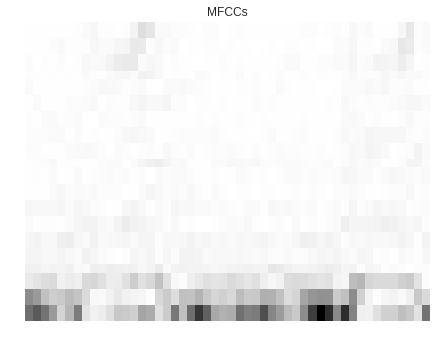

In [29]:
mfcc = AudioFeatureDataset(data_df, ROOT_PATH,
                                    audio_transform=mfcc_transform,
                                    image_transform=mfcc_image_transform,
                                    duration=4, librosa=True)
image_mfcc = mfcc.__getitem__(15)[0]

plt.imshow(image_mfcc[0], origin='lower')
plt.axis('off')
plt.title('MFCCs')
plt.show()

### MFCCs: Conv-3

In [30]:
%%time
mfcc_conv3_params = {
    'bs': 30,
    'preprocess': preprocess_nb,
    'epochs': 40,
    'lr': 0.001,
    'l2': 0.005
}

mfcc_conv3 = CVModel(data_df, 5, ROOT_PATH,
                        mfcc_transform, nb_image_transform,
                        4, librosa=True)
mfcc_conv3.train_cnn(nb_conv3_model,
               mfcc_conv3_params)

Fold 1 / 5:
Training the model on the GPU
Epoch: 0; Train loss: 2.9830607399344444; Validation loss: 3.1687569618225098
Epoch: 5; Train loss: 0.4641781747341156; Validation loss: 0.6239897012710571
Epoch: 10; Train loss: 0.4065818153321743; Validation loss: 0.6039218306541443
Epoch: 15; Train loss: 0.36904476583004; Validation loss: 0.5676190257072449
Epoch: 20; Train loss: 0.3246744032949209; Validation loss: 0.5670858025550842
Epoch: 25; Train loss: 0.2987660225480795; Validation loss: 0.5475795269012451
Epoch: 30; Train loss: 0.2868201620876789; Validation loss: 0.6401988863945007
Epoch: 35; Train loss: 0.2655208669602871; Validation loss: 0.5800463557243347
----------------------------------------
Accuracy: 69.64285714285714
Confusion matrix:
 [[21 12]
 [ 5 18]]
----------------------------------------
Fold 2 / 5:
Training the model on the GPU
Epoch: 0; Train loss: 3.331367053091526; Validation loss: 1.736041784286499
Epoch: 5; Train loss: 0.529457576572895; Validation loss: 0.4568

In [0]:
dill.dump(mfcc_conv3, open(MODEL_PATH / 'mfcc_conv3.p', 'wb'))

### MFCCs: Conv-5

In [32]:
%%time
mfcc_conv5_params = {
    'bs': 30,
    'preprocess': preprocess_nb,
    'epochs': 40,
    'lr': 0.001,
    'l2': 0.005
}

mfcc_conv5 = CVModel(data_df, 5, ROOT_PATH,
                        mfcc_transform, nb_image_transform,
                        4, librosa=True)
mfcc_conv5.train_cnn(nb_conv5_model,
               mfcc_conv5_params)

Fold 1 / 5:
Training the model on the GPU
Epoch: 0; Train loss: 5.5126475766301155; Validation loss: 0.6746339201927185
Epoch: 5; Train loss: 0.6032781451940536; Validation loss: 0.6143430471420288
Epoch: 10; Train loss: 0.3911009319126606; Validation loss: 0.740351676940918
Epoch: 15; Train loss: 0.3889041095972061; Validation loss: 0.7033088803291321
Epoch: 20; Train loss: 0.3962031230330467; Validation loss: 0.7405994534492493
Epoch: 25; Train loss: 0.3235546201467514; Validation loss: 0.7390831708908081
Epoch: 30; Train loss: 0.31552859023213387; Validation loss: 0.7585695385932922
Epoch: 35; Train loss: 0.2877009753137827; Validation loss: 0.7161664366722107
----------------------------------------
Accuracy: 75.0
Confusion matrix:
 [[25  8]
 [ 6 17]]
----------------------------------------
Fold 2 / 5:
Training the model on the GPU
Epoch: 0; Train loss: 4.0748590007424355; Validation loss: 0.7109560966491699
Epoch: 5; Train loss: 0.6177678890526295; Validation loss: 0.571593701839

# Model analysis

## Load models

An issue with `dill` prevented the mel-scaled models from being saved. To avoid the need of rerunning them, I've copied the printed output below into a separate markdown block.

In [0]:
nblinear_conv3 = dill.load(open(MODEL_PATH / 'nblinear_conv3.p', 'rb'))
nblinear_conv5 = dill.load(open(MODEL_PATH / 'nblinear_conv5.p', 'rb'))
wblinear_conv3 = dill.load(open(MODEL_PATH / 'wblinear_conv3.p', 'rb'))
wblinear_conv5 = dill.load(open(MODEL_PATH / 'wblinear_conv5.p', 'rb'))
mfcc_conv3 = dill.load(open(MODEL_PATH / 'mfcc_conv3.p', 'rb'))
mfcc_conv3 = dill.load(open(MODEL_PATH / 'mfcc_conv3.p', 'rb'))

## Mean and median accuracy scores

In [78]:
print("="*40)
print(f"Conv-3 models")
print("-"*40)
print("Narrowband linear-scaled STFT features")
print(f"Mean: {np.mean(nblinear_conv3.acc_scores)}, SD: {np.std(nblinear_conv3.acc_scores)}, Median: {np.median(nblinear_conv3.acc_scores)}")
print(f"Confusion matrix:\n{confusion_matrix(nblinear_conv3.train_actual, nblinear_conv3.train_preds)}")
print("Wideband linear-scaled STFT features")
print(f"Mean: {np.mean(wblinear_conv3.acc_scores)}, SD: {np.std(wblinear_conv3.acc_scores)}, Median: {np.median(wblinear_conv3.acc_scores)}")
print(f"Confusion matrix:\n{confusion_matrix(wblinear_conv3.train_actual, wblinear_conv3.train_preds)}")
print("-"*20)
print("Narrowband mel-scaled STFT features")
print(f"Mean: {np.mean(nbmel_conv3.acc_scores)}, SD: {np.std(nbmel_conv3.acc_scores)}, Median: {np.median(nbmel_conv3.acc_scores)}")
print(f"Confusion matrix:\n{confusion_matrix(nbmel_conv3.train_actual, nbmel_conv3.train_preds)}")
print("Wideband mel-scaled STFT features")
print(f"Mean: {np.mean(wbmel_conv3.acc_scores)}, SD: {np.std(wbmel_conv3.acc_scores)}, Median: {np.median(wbmel_conv3.acc_scores)}")
print(f"Confusion matrix:\n{confusion_matrix(wbmel_conv3.train_actual, wbmel_conv3.train_preds)}")
print("-"*20)
print("MFCC features")
print(f"Mean: {np.mean(mfcc_conv3.acc_scores)}, SD: {np.std(mfcc_conv3.acc_scores)}, Median: {np.median(mfcc_conv3.acc_scores)}")
print(f"Confusion matrix:\n{confusion_matrix(mfcc_conv3.train_actual, mfcc_conv3.train_preds)}")
print("="*40)
print(f"Conv-5 models")
print("-"*40)
print("Narrowband linear-scaled STFT features")
print(f"Mean: {np.mean(nblinear_conv5.acc_scores)}, SD: {np.std(nblinear_conv5.acc_scores)}, Median: {np.median(nblinear_conv5.acc_scores)}")
print(f"Confusion matrix:\n{confusion_matrix(nblinear_conv5.train_actual, nblinear_conv5.train_preds)}")
print("Wideband linear-scaled STFT features")
print(f"Mean: {np.mean(wblinear_conv5.acc_scores)}, SD: {np.std(wblinear_conv5.acc_scores)}, Median: {np.median(wblinear_conv5.acc_scores)}")
print(f"Confusion matrix:\n{confusion_matrix(wblinear_conv5.train_actual, wblinear_conv5.train_preds)}")
print("-"*20)
print("Narrowband mel-scaled STFT features")
print(f"Mean: {np.mean(nbmel_conv5.acc_scores)}, SD: {np.std(nbmel_conv5.acc_scores)}, Median: {np.median(nbmel_conv5.acc_scores)}")
print(f"Confusion matrix:\n{confusion_matrix(nbmel_conv5.train_actual, nbmel_conv5.train_preds)}")
print("Wideband mel-scaled STFT features")
print(f"Mean: {np.mean(wbmel_conv5.acc_scores)}, SD: {np.std(wbmel_conv5.acc_scores)}, Median: {np.median(wbmel_conv5.acc_scores)}")
print(f"Confusion matrix:\n{confusion_matrix(wbmel_conv5.train_actual, wbmel_conv5.train_preds)}")
print("-"*40)
print("MFCC features")
print(f"Mean: {np.mean(mfcc_conv5.acc_scores)}, SD: {np.std(mfcc_conv5.acc_scores)}, Median: {np.median(mfcc_conv5.acc_scores)}")
print(f"Confusion matrix:\n{confusion_matrix(mfcc_conv5.train_actual, mfcc_conv5.train_preds)}")
print("="*40)

Conv-3 models
----------------------------------------
Narrowband linear-scaled STFT features
Mean: 87.34199134199133, SD: 3.113398424823157, Median: 89.0909090909091
Confusion matrix:
[[150  14]
 [ 21  92]]
Wideband linear-scaled STFT features
Mean: 84.1019721019721, SD: 4.910210806476869, Median: 82.14285714285714
Confusion matrix:
[[150  14]
 [ 30  83]]
--------------------
Narrowband mel-scaled STFT features
Mean: 91.6936026936027, SD: 3.320387169947564, Median: 92.72727272727273
Confusion matrix:
[[157   7]
 [ 16  97]]
Wideband mel-scaled STFT features
Mean: 88.11568061568062, SD: 4.09889005650555, Median: 90.74074074074075
Confusion matrix:
[[157   7]
 [ 26  87]]
--------------------
MFCC features
Mean: 79.80952380952381, SD: 5.257863132162466, Median: 82.14285714285714
Confusion matrix:
[[138  26]
 [ 30  83]]
Conv-5 models
----------------------------------------
Narrowband linear-scaled STFT features
Mean: 77.7056277056277, SD: 12.868825496723126, Median: 83.33333333333333
Conf

```
========================================
Conv-3 models
----------------------------------------
Narrowband linear-scaled STFT features
Mean: 87.34199134199133, SD: 3.113398424823157, Median: 89.0909090909091
Confusion matrix:
[[150  14]
 [ 21  92]]
Wideband linear-scaled STFT features
Mean: 84.1019721019721, SD: 4.910210806476869, Median: 82.14285714285714
Confusion matrix:
[[150  14]
 [ 30  83]]
--------------------
Narrowband mel-scaled STFT features
Mean: 91.6936026936027, SD: 3.320387169947564, Median: 92.72727272727273
Confusion matrix:
[[157   7]
 [ 16  97]]
Wideband mel-scaled STFT features
Mean: 88.11568061568062, SD: 4.09889005650555, Median: 90.74074074074075
Confusion matrix:
[[157   7]
 [ 26  87]]
--------------------
MFCC features
Mean: 79.80952380952381, SD: 5.257863132162466, Median: 82.14285714285714
Confusion matrix:
[[138  26]
 [ 30  83]]
========================================
Conv-5 models
----------------------------------------
Narrowband linear-scaled STFT features
Mean: 77.7056277056277, SD: 12.868825496723126, Median: 83.33333333333333
Confusion matrix:
[[150  14]
 [ 48  65]]
Wideband linear-scaled STFT features
Mean: 86.64766714766715, SD: 5.699999257410832, Median: 87.27272727272727
Confusion matrix:
[[155   9]
 [ 28  85]]
--------------------
Narrowband mel-scaled STFT features
Mean: 84.84872534872534, SD: 4.276381730499409, Median: 85.18518518518519
Confusion matrix:
[[140  24]
 [ 18  95]]
Wideband mel-scaled STFT features
Mean: 85.51010101010101, SD: 4.333760974997422, Median: 85.71428571428571
Confusion matrix:
[[146  18]
 [ 22  91]]
----------------------------------------
MFCC features
Mean: 80.86772486772487, SD: 3.995187258941439, Median: 80.35714285714286
Confusion matrix:
[[137  27]
 [ 26  87]]
========================================
```

The highest accuracy is achieved by Conv-3 with narrowband mel-scaled STFT features. With the exception of the narrowband linear-scaled STFT features (and, narrowly, the MFCCs), the shallowed Conv-3 model performed better than the deeper Conv-5 model. Huzaifah (2017: 4) found similar for environmental sounds and attributed it to a tendency of the Conv-5 model to overfit to the training data.

The confusion matrices for the Conv-3 models indicate that the use of narrowband features leads to a more accurate classification of dog vocalisations with no change in the accuracy of cat classifications. This suggests that a) for at least some dog vocalisations, greater resolution in the time domain leads to greater accuracy and b) while more cat vocalisations are associated with changes in the frequency domain, narrowband transformations capture enough frequency-domain variation to maintain classification accuracy.

## Overfitting for narrowband mel-scaled STFT Conv-3

While the Conv-3 model with narrowband mel-scaled STFT spectrogram features was found to have the highest classification accuracy, inspection of the training and validation loss curves showed considerable overfitting for several of the cross-validation folds, most notably folds 1 and 3. These losses, as well as the model accuracy per epoch, for each fold is shown below:

CV fold 1 of 5


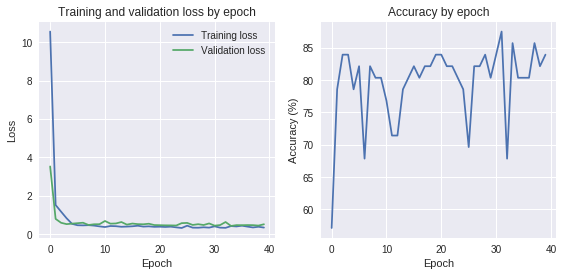

CV fold 2 of 5


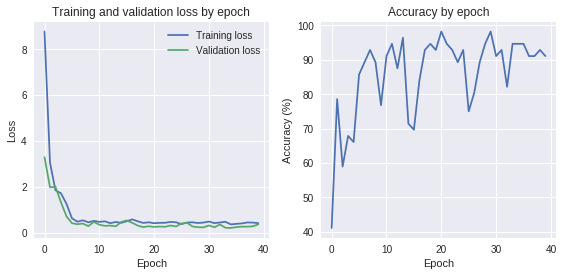

CV fold 3 of 5


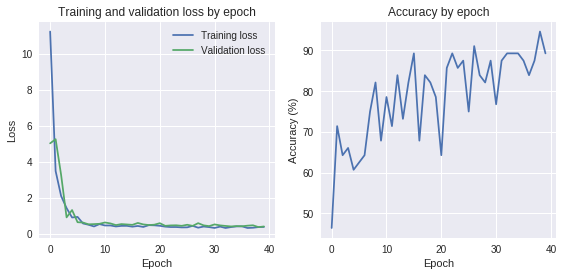

CV fold 4 of 5


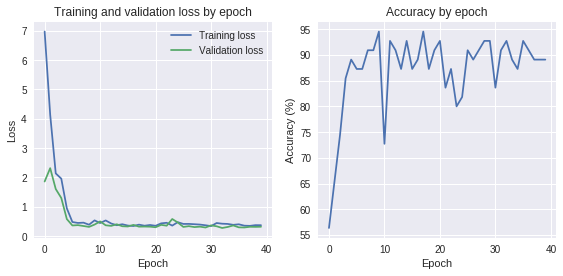

CV fold 5 of 5


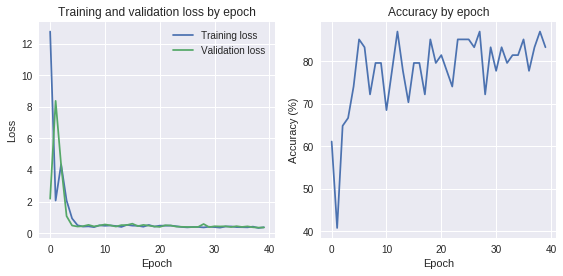

In [86]:
for i in range(len(nbmel_conv3.train_loss)):
    print(f"CV fold {i+1} of {len(nbmel_conv3.train_loss)}")
    _, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].plot(nblinear_conv3.train_loss[i], label="Training loss")
    ax[0].plot(nblinear_conv3.valid_loss[i], label="Validation loss")
    ax[0].set_title("Training and validation loss by epoch")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")
    ax[0].legend(loc='upper right')
    ax[1].plot(nblinear_conv3.epoch_accuracy[i])
    ax[1].set_title("Accuracy by epoch")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Accuracy (%)")
    plt.tight_layout()
    plt.show()

# Proposed next steps

Despite the very small size of the current data set, the Conv-3 model shows promising accuracy when making using narrowband mel-scaled spectrograms as the input feature set. In addition, performing the feature extraction on the GPU with `torchaudio` has allowed the models to be trained much more quickly than would be possible with a CPU-based audio feature library like `librosa`.

The current results could likely be improved further. First, examination of the training and validation losses showed some degree of overfitting, even for the best model. Within the current Conv-3 architecture, overfitting may be reduced by adjusting the dropout hyperparameters. Second, all raw audio was clipped/padded to a 4-second duration. There is some suggestion that the time domain may be more important than the frequency domain for identifying some dog vocalisations and clipping longer audio may have removed some valuable information. Using larger (perhaps 6 or 8 second) audio clips may lead to greater classification accuracy, albeit at the cost of a somewhat-greater training time.

There are additional options outside the current architectures. Transfer learning, even for a model not trained on acoustic images, might outperform the best model here. So, too, might the use of e.g. resnet architectures. It might also be possible to achieve considerable accuracy using a 1-dimensional convolution in the time domain alone rather than the frequency-time representations used in the current projects.